In [1]:
#!jupyter nbconvert --to=python LIMfactors_python3.ipynb

# After changes in the script using Jupyter notebook, save the notebook, run this line, and clear the output.

In [47]:
class LimFact:
    '''
    class LimFact
    
    Derive and plot most limiting factor (nutrient vs. light) at surface
    
    '''
    def __init__(self,resultpath,savepath,mesh,first_year,last_year,
                 mapproj='pc',
                 cmap = 'viridis',
                 savefig=False,
                 verbose=True,
                 plotting=True,
                 output=True,
                 frequency='yearly',
                 runname='fesom'):

        self.runname = runname
        self.resultpath = resultpath
        self.savepath = savepath
        self.mesh = mesh
        self.fyear = first_year
        self.lyear = last_year
        self.mapproj = mapproj
        self.cmap = cmap
        self.savefig = savefig
        self.verbose = verbose
        self.plotting = plotting
        self.frequency = frequency
        self.output = output
        
        import matplotlib.pyplot as plt
        import numpy as np
        import skill_metrics as sm
        import cartopy.crs as ccrs
        import pyfesom2 as pf
        from load_interp_WOA import WOAdata
        from Py_f2recom_toolbox import plt_Taylor_norm
        from Py_f2recom_toolbox import plt_Taylor_comp
        
        if self.mapproj == 'rob':
            box=[-180, 180, -90, 90]
        elif self.mapproj == 'pc':
            box=[-180, 180, -90, 90]
        elif self.mapproj == 'sp':
            box=[-180, 180, -90, -30]
        elif self.mapproj == 'np':
            box=[-180, 180, 60, 90]
            
        self.mapproj = pf.get_proj(self.mapproj)
        
        # load FESOM data -------------------------------------------------------------------------------------
        #print('Processing ' + self.resultpath)
        
        #mesh       = pf.load_mesh(self.meshpath)
        years = np.arange(self.fyear, self.lyear+1,1)
        
        # model parameters
        alfa_phy, alfa_dia, Pcm, Pcm_d, C2K, rTref, Ae = 0.14, 0.19, 3.0, 3.5, 273.15, 1/288.15, 4500.0
        NMinSlope, SiMinSlope, NCmin, SiCmin  = 50, 1000, 0.04, 0.04
        
        for year in years:
            print(year)
            year = int(year)
            
            # ==============================================================================
            # Loading data
            
            if frequency == 'monthly':
                print('monthly frequency selected')
                Felimphy          = np.zeros(shape=(12,len(mesh.x2)))
                Felimdia          = np.zeros(shape=(12,len(mesh.x2)))
                Nlimphy           = np.zeros(shape=(12,len(mesh.x2)))
                Nlimdia           = np.zeros(shape=(12,len(mesh.x2)))
                Silim             = np.zeros(shape=(12,len(mesh.x2)))
                Phy_Light_limiter = np.zeros(shape=(12,len(mesh.x2)))
                Dia_Light_limiter = np.zeros(shape=(12,len(mesh.x2)))

                DIN = pf.get_data(self.resultpath, "DIN", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                DSi = pf.get_data(self.resultpath, "DSi", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                DFe = pf.get_data(self.resultpath, "DFe", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                PhyC = pf.get_data(self.resultpath, "PhyC", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                PhyN = pf.get_data(self.resultpath, "PhyN", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                PhyChl = pf.get_data(self.resultpath, "PhyChl", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                DiaSi = pf.get_data(self.resultpath, "DiaSi", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                DiaC = pf.get_data(self.resultpath, "DiaC", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                DiaN = pf.get_data(self.resultpath, "DiaN", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                DiaChl = pf.get_data(self.resultpath, "DiaChl", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                temp = pf.get_data(self.resultpath, "temp", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                PAR = pf.get_data(self.resultpath, "PAR", year, mesh, 
                                   how=None, compute=True, runid=self.runname, silent=True)

                print(np.shape(DIN))

                DIN = DIN[:,:,0]
                DSi = DSi[:,:,0]
                DFe = DFe[:,:,0]
                PhyC = PhyC[:,:,0]
                PhyN = PhyN[:,:,0]
                PhyChl = PhyChl[:,:,0]
                DiaSi = DiaSi[:,:,0]
                DiaC = DiaC[:,:,0]
                DiaN = DiaN[:,:,0]
                DiaChl = DiaChl[:,:,0]
                temp = temp[:,:,0]
                PAR = PAR[:,:,0]

                print(np.shape(DIN))

                for m in range(0,12):
                    DIN2D = DIN[m,:]
                    DSi2D = DSi[m,:]
                    DFe2D = DFe[m,:]
                    phyc2D = PhyC[m,:]
                    phyn2D = PhyN[m,:]
                    phychl2D = PhyChl[m,:]
                    diac2D = DiaC[m,:]
                    dian2D = DiaN[m,:]
                    diasi2D = DiaSi[m,:]
                    diachl2D = DiaChl[m,:]
                    par2d = PAR[m,:]
                    T2d = temp[m,:]

                    # For every month in every year, the limitation is calculated
                    Nlimphy[m,:]  = DIN2D/(DIN2D+0.55)
                    Nlimdia[m,:]  = DIN2D/(DIN2D+1.0)

                    Silim[m,:]    = DSi2D/(DSi2D+4.0)

                    Felimphy[m,:] = DFe2D/(DFe2D+0.04)
                    Felimdia[m,:] = DFe2D/(DFe2D+0.12)

                    # Quotas
                    phychl2c = phychl2D/phyc2D 
                    phyn2c   = phyn2D/phyc2D
                    diachl2c = diachl2D/diac2D
                    dian2c   = dian2D/diac2D
                    diasi2c  = diasi2D/diac2D

                    # Temperature dependece
                    T2d = 1./(T2d + C2K)
                    T2d = np.exp( -Ae * (T2d - rTref));

                    # Nutrient growth limitation
                    Phy_dq              = NCmin - phyn2c
                    Phy_recom_limiter   = 1.0 - np.exp( -NMinSlope*( abs(Phy_dq)-Phy_dq )**2)

                    Dia_dq              = NCmin - dian2c
                    Dia_recom_limiterN  = 1.0 - np.exp( -NMinSlope*( abs(Dia_dq)-Dia_dq )**2)
                    Dia_dq              = SiCmin - diasi2c;
                    Dia_recom_limiterSi = 1.0 - np.exp( -SiMinSlope*( abs(Dia_dq)-Dia_dq )**2)

                    # Most limiting factor 
                    Fephy       = DFe2D/(DFe2D+0.02)
                    Phy_qlimFac = np.column_stack((Phy_recom_limiter,Fephy))
                    Phy_qlimFac = Phy_qlimFac.min(axis=1)

                    Fedia       = DFe2D/(DFe2D+0.12)
                    Dia_qlimFac = np.column_stack((Dia_recom_limiterN,Dia_recom_limiterSi,Fedia))
                    Dia_qlimFac = Dia_qlimFac.min(axis=1)

                    # pmax
                    Pmax_phy = Pcm * Phy_qlimFac * T2d
                    Pmax_dia = Pcm_d * Dia_qlimFac * T2d

                    Phy_Light_limiter[m,:] = 1 - np.exp((-alfa_phy * phychl2c * par2d)/Pmax_phy)
                    Dia_Light_limiter[m,:] = 1 - np.exp((-alfa_dia * diachl2c * par2d)/Pmax_dia)

                    #tracer = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12]

                    # Most limiting factors found for nano
                    # 0 = Fe, 1 = DIN, 2 = Light
                    lim=np.column_stack((Felimphy[m,:],Nlimphy[m,:],Phy_Light_limiter[m,:]))
                    limphy1=lim.argmin(axis=1)

                    # Most limiting factors found for dia
                    # 0 = Fe, 1 = DIN, 2 = DSi, 3 = Light
                    lim=np.column_stack((Felimdia[m,:],Nlimdia[m,:],Silim[m,:],Dia_Light_limiter[m,:]))
                    limdia1=lim.argmin(axis=1)
                    
                    limphy1 = (np.array(limphy1, dtype = float) + 1) # .astype('Float32')
                    limdia1 = (np.array(limdia1, dtype = float) + 1) # .astype('Float32')
                    
                    if True:
                        self.limphy = limphy1
                        self.limdia   = limdia1
        
                    if self.plotting:
                        fig = plt.figure(figsize=(8,10), constrained_layout=True)
                        axes = fig.subplot_mosaic(
                                    """
                                    A
                                    B
                                    """,
                                    gridspec_kw={'hspace': 0.01, 'wspace': 0.01}, 
                                    subplot_kw=dict(projection=self.mapproj))
                        fig.get_layout_engine().set(w_pad=0.2)
                        
                        m1 = axes['A']
                        levels = np.arange(0,25,1)
                        f1 = pf.subplot(mesh, fig, m1, self.limdia,
                                    levels = np.arange(0.5,3.5,1),
                                    units='', 
                                    mapproj=self.mapproj, # robinson projection takes more time!
                                    cmap = self.cmap,
                                    cmap_extension='neither',
                                    titles='Diatoms limiting factor',
                                    box = box,
                                   )

                        m2 = axes['B']
                        f2 = pf.subplot(mesh, fig, m2, self.limphy, 
                                    levels = np.arange(0.5,3.5,1),
                                    units='', 
                                    mapproj=self.mapproj, # robinson projection takes more time!
                                    cmap = self.cmap,
                                    cmap_extension='neither',
                                    titles='Small phytoplankton limiting factor',
                                    boz = box,
                                   )
                        m1.text(-0.12, 1.05, 'A', transform=m1.transAxes,
                                    size=30, weight='bold')
                        m2.text(-0.12, 1.05, 'B', transform=m2.transAxes,
                                    size=30, weight='bold')
            
                        fig.subplots_adjust(bottom=0.1)
                        cbar1_ax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
                        cbar1 = fig.colorbar(f2,
                                        cax = cbar1_ax, 
                                        orientation = 'horizontal',
                                        fraction=0.046, pad=0.04, ticks=[1,2]) 
                        #cbar1.set_label('Limiting Factor', fontsize=18)
                        cbar1.ax.tick_params(labelsize=18)
                        cbar1.ax.set_xticklabels(['Nutrients', 'Ligth'])  
                    
                        # fig export  -------------------------------------------------------------------------------------
                        if(self.savefig==True):                
                            plt.savefig(self.savepath+self.runname+'_'+'LIMFact'+'_'+str(years[0])+'to'+str(years[-1])+'.png', 
                                    dpi = 300, bbox_inches='tight')
                            plt.savefig(self.savepath+self.runname+'_'+'LIMFact'+'_'+str(years[0])+'to'+str(years[-1])+'.pdf', 
                                    bbox_inches='tight')
                        plt.show(block=False)
                    
            elif frequency == 'yearly':
                    print('yearly frequency selected')
                    Felimphy          = np.zeros(shape=(len(mesh.x2)))
                    Felimdia          = np.zeros(shape=(len(mesh.x2)))
                    Nlimphy           = np.zeros(shape=(len(mesh.x2)))
                    Nlimdia           = np.zeros(shape=(len(mesh.x2)))
                    Silim             = np.zeros(shape=(len(mesh.x2)))
                    Phy_Light_limiter = np.zeros(shape=(len(mesh.x2)))
                    Dia_Light_limiter = np.zeros(shape=(len(mesh.x2)))

                    DIN = pf.get_data(self.resultpath, "DIN", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    DSi = pf.get_data(self.resultpath, "DSi", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    DFe = pf.get_data(self.resultpath, "DFe", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    PhyC = pf.get_data(self.resultpath, "PhyC", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    PhyN = pf.get_data(self.resultpath, "PhyN", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    PhyChl = pf.get_data(self.resultpath, "PhyChl", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    DiaSi = pf.get_data(self.resultpath, "DiaSi", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    DiaC = pf.get_data(self.resultpath, "DiaC", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    DiaN = pf.get_data(self.resultpath, "DiaN", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    DiaChl = pf.get_data(self.resultpath, "DiaChl", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    temp = pf.get_data(self.resultpath, "temp", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    PAR = pf.get_data(self.resultpath, "PAR", year, mesh, 
                                       how="mean", compute=True, runid=self.runname, silent=True)

                    DIN2D = DIN[:,0]
                    DSi2D = DSi[:,0]
                    DFe2D = DFe[:,0]
                    phyc2D = PhyC[:,0]
                    phyn2D = PhyN[:,0]
                    phychl2D = PhyChl[:,0]
                    diasi2D = DiaSi[:,0]
                    diac2D = DiaC[:,0]
                    dian2D = DiaN[:,0]
                    diachl2D = DiaChl[:,0]
                    T2d = temp[:,0]
                    par2d = PAR[:,0]

                    # For every month in every year, the limitation is calculated
                    Nlimphy  = DIN2D/(DIN2D+0.55)
                    Nlimdia  = DIN2D/(DIN2D+1.0)

                    Silim    = DSi2D/(DSi2D+4.0)

                    Felimphy = DFe2D/(DFe2D+0.02)
                    Felimdia = DFe2D/(DFe2D+0.12)

                    # Quotas
                    phychl2c = phychl2D/phyc2D 
                    phyn2c   = phyn2D/phyc2D
                    diachl2c = diachl2D/diac2D
                    dian2c   = dian2D/diac2D
                    diasi2c  = diasi2D/diac2D

                    # Temperature dependece
                    T2d = 1./(T2d + C2K)
                    T2d = np.exp( -Ae * (T2d - rTref));

                    # Nutrient growth limitation
                    Phy_dq              = NCmin - phyn2c
                    Phy_recom_limiter   = 1.0 - np.exp( -NMinSlope*( abs(Phy_dq)-Phy_dq )**2)

                    Dia_dq              = NCmin - dian2c
                    Dia_recom_limiterN  = 1.0 - np.exp( -NMinSlope*( abs(Dia_dq)-Dia_dq )**2)
                    Dia_dq              = SiCmin - diasi2c;
                    Dia_recom_limiterSi = 1.0 - np.exp( -SiMinSlope*( abs(Dia_dq)-Dia_dq )**2)

                    # Most limiting factor 
                    Fephy       = DFe2D/(DFe2D+0.02)
                    Phy_qlimFac = np.column_stack((Phy_recom_limiter,Fephy))
                    Phy_qlimFac = Phy_qlimFac.min(axis=1)

                    Fedia       = DFe2D/(DFe2D+0.12)
                    Dia_qlimFac = np.column_stack((Dia_recom_limiterN,Dia_recom_limiterSi,Fedia))
                    Dia_qlimFac = Dia_qlimFac.min(axis=1)

                    # pmax
                    Pmax_phy = Pcm * Phy_qlimFac * T2d
                    Pmax_dia = Pcm * Dia_qlimFac * T2d

                    Phy_Light_limiter = 1 - np.exp((-alfa_phy * phychl2c * par2d)/Pmax_phy)
                    Dia_Light_limiter = 1 - np.exp((-alfa_dia * diachl2c * par2d)/Pmax_dia)


                    # Most limiting factors found for nano
                    # 0 = Fe, 1 = DIN, 2 = Light
                    lim=np.column_stack((Felimphy,Nlimphy,Phy_Light_limiter))
                    limphy1=lim.argmin(axis=1)

                    # Most limiting factors found for dia
                    # 0 = Fe, 1 = DIN, 2 = DSi, 3 = Light
                    lim=np.column_stack((Felimdia,Nlimdia,Silim,Dia_Light_limiter))
                    limdia1=lim.argmin(axis=1)
                    
                    limphy1 = (np.array(limphy1, dtype = float) + 1) # .astype('Float32')
                    limdia1 = (np.array(limdia1, dtype = float) + 1) # .astype('Float32')
                    
                    # Find where none is limiting for hatching (>0.5)
                    nolimphy = np.random.rand(*np.shape(limphy1))
                    nolimdia = np.random.rand(*np.shape(limdia1))
                    
                    nolimphy[np.where((Felimphy > 0.5) & (Nlimphy > 0.5) & (Phy_Light_limiter > 0.5))] = -1
                    nolimdia[np.where((Felimdia > 0.5) & (Nlimdia > 0.5) & (Silim > 0.5) & (Dia_Light_limiter > 0.5))] = -1
                    
                    if True:
                        self.limphy = limphy1
                        self.limdia   = limdia1
                        self.nolimdia = nolimdia
                        self.Felimphy = Felimphy
                        self.Nlimphy = Nlimphy
                        self.Phy_Light_limiter = Phy_Light_limiter
        
                    if self.plotting:
                        fig = plt.figure(figsize=(8,10), constrained_layout=True)
                        axes = fig.subplot_mosaic(
                                    """
                                    A
                                    B
                                    """,
                                    gridspec_kw={'hspace': 0.01, 'wspace': 0.01}, 
                                    subplot_kw=dict(projection=self.mapproj))
                        fig.get_layout_engine().set(w_pad=0.2)
                        
                        m1 = axes['A']
                        levels = np.arange(0,25,1)
                        f1 = pf.subplot(mesh, fig, m1, self.limdia,
                                    levels = np.arange(0.5,5.5,1),
                                    units='', 
                                    mapproj=self.mapproj, # robinson projection takes more time!
                                    cmap = self.cmap,
                                    cmap_extension='neither',
                                    titles='Diatoms limiting factor',
                                    box = box,
                                   )
                        
                        f1a = pf.subhatch(mesh, fig, m1, nolimdia)
                        
                        cbar0_ax = fig.add_axes([0.25, 0.54, 0.6, 0.02])
                        cbar0 = fig.colorbar(f1,
                                        cax = cbar0_ax, 
                                        orientation = 'horizontal',
                                        fraction=0.046, pad=0.04, ticks=[1,2,3,4]) 
                        #cbar0.set_label('Limiting Factor', fontsize=18)
                        cbar0.ax.tick_params(labelsize=18)
                        cbar0.ax.set_xticklabels(['Fe', 'DIN', 'DSi', 'Light']) 

                        m2 = axes['B']
                        f2 = pf.subplot(mesh, fig, m2, self.limphy, 
                                    levels = np.arange(0.5,4.5,1),
                                    units='', 
                                    mapproj=self.mapproj, # robinson projection takes more time!
                                    cmap = self.cmap,
                                    cmap_extension='neither',
                                    titles='Small phytoplankton limiting factor',
                                    box = box,
                                   )
                        
                        f2a = pf.subhatch(mesh, fig, m2, nolimphy)
                        
                        m1.text(-0.1, 1.05, 'A', transform=m1.transAxes,
                                    size=30, weight='bold')
                        m2.text(-0.1, 1.05, 'B', transform=m2.transAxes,
                                    size=30, weight='bold')
                        
                        fig.subplots_adjust(bottom=0.2)
                        cbar1_ax = fig.add_axes([0.25, 0.04, 0.6, 0.02])
                        cbar1 = fig.colorbar(f2,
                                        cax = cbar1_ax, 
                                        orientation = 'horizontal',
                                        fraction=0.046, pad=0.04, ticks=[1,2,3]) 
                        #cbar1.set_label('Limiting Factor', fontsize=18)
                        cbar1.ax.tick_params(labelsize=18)
                        cbar1.ax.set_xticklabels(['Fe', 'DIN', 'Light'])  
                        
                        # fig export  -------------------------------------------------------------------------------------
                        if(self.savefig==True):                
                            plt.savefig(self.savepath+self.runname+'_'+'LIMFact'+'_'+str(years[0])+'to'+str(years[-1])+'.png', 
                                    dpi = 300, bbox_inches='tight')
                            plt.savefig(self.savepath+self.runname+'_'+'LIMFact'+'_'+str(years[0])+'to'+str(years[-1])+'.pdf', 
                                    bbox_inches='tight')
                        plt.show(block=False)
                    
            else:
                print('no frequency selected')

In [48]:
# import warnings
# warnings.filterwarnings('ignore')

# %matplotlib inline
# %autosave 5

# # necessary modules -------------------------------------------------------------------------------------
# import sys
# import os
# sys.path.append('/home/ollie/loziel/pyfesom2/codes/py_f2recom_develop/modules/')
# import pyfesom2 as pf
# sys.path.append('/home/ollie/loziel/pyfesom2/codes/py_f2recom_develop/modules/SkillMetrics/')
# import skill_metrics as sm
# sys.path.append('/home/ollie/loziel/pyfesom2/codes/py_f2recom_develop/modules/cmocean-master/')
# import cmocean as cmo

# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# import time
# from datetime import date
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from netCDF4 import Dataset

Autosaving every 5 seconds


In [49]:
# #    Only modify parameters and paths in this cell       #
# #  In principle, you don't have to modify anything else  #


# # run specification -------------------------------------------------------------------------------------   
# runid      =  'fesom'
# simu_name = 'A'

# # defines paths ----------------------------------------------------------------------------------------- 

# #resultpath = '/work/ollie/ogurses/output_f2r2/spinup_1800_1850/A'
# resultpath ='/work/ollie/ogurses/output_f2r2/fesom2.1_recom_New_Initial_Conditions/'+simu_name+'/'
# #resultpath ='/work/ollie/loziel/model_output/fesom2.1_recom/'+simu_name+'/'

# #meshpath = '/work/ollie/loziel/mesh/fArc/'
# #meshpath = '/work/ollie/clidyn/FESOM2/meshes/farc/'
# meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

# savepath = '/home/ollie/loziel/pyfesom2/codes/py_f2recom_develop/outputs/'+simu_name+'/'

# # period of analysis ------------------------------------------------------------------------------------
# first_year_maps = 2011
# first_year = 1958
# last_year  = 2020
    
# years = np.arange(first_year,last_year+1,1)
# years_last10 = np.arange(first_year_maps,last_year+1,1)

# # specification of analysis ------------------------------------------------------------------------------------

# layerwise = False
# depths = (0,50,200,1000,2000) # If layerwise is True, you can define depths here, by defaut: (0,50,200,1000,2000,4000)
# depth_limit = 50
# mapproj = 'rob'
# #Map projection. Options are Mercator (merc), Plate Carree (pc),
# #North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
# #Robinson projection is quite time consuming.

In [50]:
# # export of analysis ------------------------------------------------------------------------------------
# # Be aware that exporting figures may alter (crop) the display but the printed figures are okay
# # This is because of bugs in the 'constrained_layout' matplotlib experimental function 
# # that may be fixed in the future matplotlib version
# # If you prefer having a nice HTML, savefig must be turned off
# #--------------------------------------------------------------------------------------------------------
# today = date.today().strftime("_%Y_%m_%d")
# savefig = True 
# htmlname     =  simu_name+'_'+ today +'.html'
# htmlpath = savepath
# verbose = False

# if not os.path.exists(htmlpath): # create folders if do not exist
#     os.makedirs(htmlpath)
# if not os.path.exists(savepath):
#     os.makedirs(savepath)
    
# # initialization file specifications -----------------------------------------------------------

# evalpath      = '/work/ollie/projects/MarESys/evaluation/'
# evalpath2      = '/work/ollie/ogurses/input/corrected_input/'

# ncfileAlk                = evalpath2+'GLODAPv2.2016b.TAlk_mmol.nc'
# ncfileDIC                = evalpath2+'GLODAPv2.2016b.TCO2_mmol.nc'
# ncfileDSi                = evalpath2+'woa13_all_i00_01_fesom2.nc'
# ncfileDIN                = evalpath2+'woa13_all_n00_01_fesom2.nc'
# ncfileDO2                = evalpath2+'woa18_all_o00_01_mmol_fesom2.nc'
# ncfileDFe                = evalpath2+'fe_pisces_opa_eq_init_3D_changed_name.nc' 
# ncfileNPPTotalGlobal     = evalpath+'fesom.initial.mesh.diag.nc'
# ncfileCO2fluxTotalGlobal = evalpath+'fesom.initial.mesh.diag.nc'
# ncfileTemp               = evalpath2+'woa18_decav_t00_01_fesom2.nc'
# ncfileSal                = evalpath2+'woa18_decav_s00_01_fesom2.nc'
# ncfilePHC3               = evalpath2+'phc3.0_annual.nc'      
# #ncfilepCO2               = evalpath+'SOCATv6_tracks_gridded_monthly.nc'
# ncfilepCO2               = '/home/ollie/loziel/SOCATv2020_tracks_gridded_monthly.nc'
# ncfileCO2f               = '/home/ollie/loziel/dataset_CO2_Chauetal2020.nc'
# ncfileMLD                = evalpath+'mld_DR003.nc'
# matfileChlsurf           = evalpath+'climatology_annual_chl_1deg_OCCCI_2012_2015.mat'
# txtfileCO2flux           = evalpath+'CO2_flux2015_Takahashietal2009_original.txt'
# ncfileMaredat            = evalpath+'MarEDat20120716Diatoms.nc'
# ncfileJohnson2013        = evalpath+'Johnson2013_MEAN_1x1_Chl_mg_m3.npy'
# matfileNPPvgpn           = evalpath+'VGPN_CLIM.mat'
# matfileNPPcpbm           = evalpath+'CBPM_CLIM.mat'
# matfileMLD               = evalpath+'GlobalML_Climato_1970_2018.mat'

# # just to check
# if(verbose):
#     print('Processing years {4} to {5}\n\nReading out of {0}\nStoring graphs to {1}\nStoring html to {2} as {3}'.format(
#         resultpath, savepath, htmlpath, htmlname,years[0],years[-1]))

#     print('\nLast ten years are \n{0}'.format(years_last10))
    
# # mesh initialization -----------------------------------------------------------
# mesh = pf.load_mesh(meshpath)

# if False: # check mesh setup nodal and area
#     print(mesh)
#     print('with depth levels:')
#     print(mesh.zlev)
    
#     print('\n\nFESOM mesh.diag:')
#     meshdiag=resultpath+'/'+runid+'.mesh.diag.nc'
#     #!ncdump -h $meshdiag

#     diag = pf.get_meshdiag(mesh,meshdiag=meshdiag, runid=runid)
#     print(diag)
#     print('depth of layers:')
#     mesh_depths = diag['nz1'].values
#     #print(mesh_depths)
    
#     nod_area = diag.nod_area
#     nod_area.load()
#     #print(np.shape(nod_area[:,:]), type(nod_area)) 

# if(verbose):
#     print(mesh_depths)
#     print(diag)

/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz/pickle_mesh_py3_fesom2


2020
yearly frequency selected
(126858, 47)
(126858, 47)


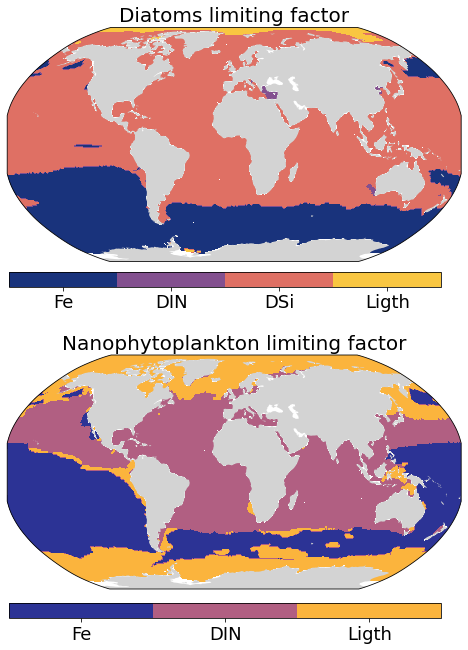

In [51]:
# limfact = LimFact(runid,resultpath,savepath,mesh,2020,2020,mapproj=mapproj,
#                 savefig=savefig,cmap = cmo.cm.thermal,verbose=verbose,frequency = 'yearly', plotting=True)